In [1]:
import os
import re
import matplotlib.pyplot as plt

In [2]:
def extract_values(file_path, structured=True):
    triplet_acc_50 = None
    total_params = None

    with open(file_path, 'r') as file:
        for line in file:
            if "Eval: 3d triplet Acc@50 :" in line:
                triplet_acc_50 = float(line.split(":")[-1].strip())
            if structured and "Total Parameters:" in line:
                total_params = int(line.split(":")[-1].strip().replace(',', ''))
            if not structured and "Total Parameters after Unstructured pruning:" in line:
                total_params = int(line.split(":")[-1].strip().replace(',', ''))
    return triplet_acc_50, total_params

In [3]:
def process_folders(base_path, structured=True):
    results = []
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            file_path = os.path.join(folder_path, 'result.txt')
            if os.path.isfile(file_path):
                triplet_acc_50, total_params = extract_values(file_path, structured)
                if triplet_acc_50 is not None and total_params is not None:
                    if 'baseline' in folder_name:
                        ratio = 0
                    else:
                        ratio = re.search(r'st(\d+)', folder_name)
                        if ratio:
                            ratio = int(ratio.group(1)) / 100
                    results.append((ratio, triplet_acc_50, total_params))
    return results

In [4]:
def plot_results(title, structured_results, unstructured_results, additional_structured_results, additional_unstructured_results):
    structured_results.sort()
    unstructured_results.sort()
    additional_structured_results.sort()
    additional_unstructured_results.sort()

    # Baseline 값 찾기 및 분리
    baseline_structured = [result for result in structured_results if result[0] == 0]
    baseline_unstructured = [result for result in unstructured_results if result[0] == 0]

    # Baseline을 제외한 나머지 structured 결과
    structured_results = [result for result in structured_results if result[0] != 0]
    unstructured_results = [result for result in unstructured_results if result[0] != 0]

    struct_ratios, struct_accs, _ = zip(*structured_results) if structured_results else ([], [], [])
    unstruct_ratios, unstruct_accs, _ = zip(*unstructured_results) if unstructured_results else ([], [], [])
    add_struct_ratios, add_struct_accs = zip(*additional_structured_results) if additional_structured_results else ([], [])
    add_unstruct_ratios, add_unstruct_accs = zip(*additional_unstructured_results) if additional_unstructured_results else ([], [])

    plt.figure(figsize=(10, 6))

    # Baseline 값 그리기 (다른 색상으로)
    if baseline_structured:
        _, baseline_acc, _ = baseline_structured[0]
        plt.scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        plt.text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')

    if baseline_unstructured:
        _, baseline_acc, _ = baseline_unstructured[0]
        plt.scatter(0, baseline_acc, color='#FF0000', label='Baseline', zorder=5)
        plt.text(0, baseline_acc, f'{baseline_acc:.2f}', fontsize=9, verticalalignment='bottom')
        
        
    # Structured Pruning 결과 그리기 (baseline을 제외하고)
    if structured_results:
        plt.plot(struct_ratios, struct_accs, marker='o', linestyle='-', label='Structured Pruning', color='#6C946F')
        # for ratio, acc in structured_results:
        #     plt.text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    # Additional Structured Results 그리기
    if additional_structured_results:
        plt.plot(add_struct_ratios, add_struct_accs, marker='*', linestyle='--', label='Structured Pruning + Fine-tuning', color='#6C946F')
        for ratio, acc in additional_structured_results:
            plt.text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')
        

    # Unstructured Pruning 결과 그리기
    if unstructured_results:
        plt.plot(unstruct_ratios, unstruct_accs, marker='o', linestyle='-', label='Unstructured Pruning', color='#DC0083')
        # for ratio, acc in unstructured_results:
        #     plt.text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')


    # Additional Unstructured Results 그리기
    if additional_unstructured_results:
        plt.plot(add_unstruct_ratios, add_unstruct_accs, marker='*', linestyle='--', label='Unstructured Pruning + Fine-tuning', color='#DC0083')
        for ratio, acc in additional_unstructured_results:
            plt.text(ratio, acc, f'{acc:.2f}', fontsize=9, verticalalignment='bottom')

    plt.xlabel('Pruning Ratio')
    plt.ylabel('3d triplet Acc@50')
    plt.title(title)
    plt.xticks([i/100 for i in range(0, 76, 5)])  # X축의 눈금을 0부터 0.75까지 0.05 간격으로 설정
    plt.grid(True)
    plt.legend()
    plt.show()


Structured - Pruning Ratio: 0.05, Eval: 3d triplet Acc@50: 89.36096375985325
Structured - Pruning Ratio: 0.35, Eval: 3d triplet Acc@50: 88.81810520053543
Structured - Pruning Ratio: 0.25, Eval: 3d triplet Acc@50: 89.20232016260968
Structured - Pruning Ratio: 0.45, Eval: 3d triplet Acc@50: 87.93812899707501
Structured - Pruning Ratio: 0.1, Eval: 3d triplet Acc@50: 89.43284913985424
Structured - Pruning Ratio: 0.6, Eval: 3d triplet Acc@50: 81.22304298249963
Structured - Pruning Ratio: 0.4, Eval: 3d triplet Acc@50: 88.54543651777304
Structured - Pruning Ratio: 0.65, Eval: 3d triplet Acc@50: 79.83739031282535
Structured - Pruning Ratio: 0.7, Eval: 3d triplet Acc@50: 78.13445044866393
Structured - Pruning Ratio: 0.5, Eval: 3d triplet Acc@50: 86.64171335085022
Structured - Pruning Ratio: 0, Eval: 3d triplet Acc@50: 89.33617569778394
Structured - Pruning Ratio: 0.2, Eval: 3d triplet Acc@50: 89.30890882950771
Structured - Pruning Ratio: 0.15, Eval: 3d triplet Acc@50: 89.39814585295721
Structur

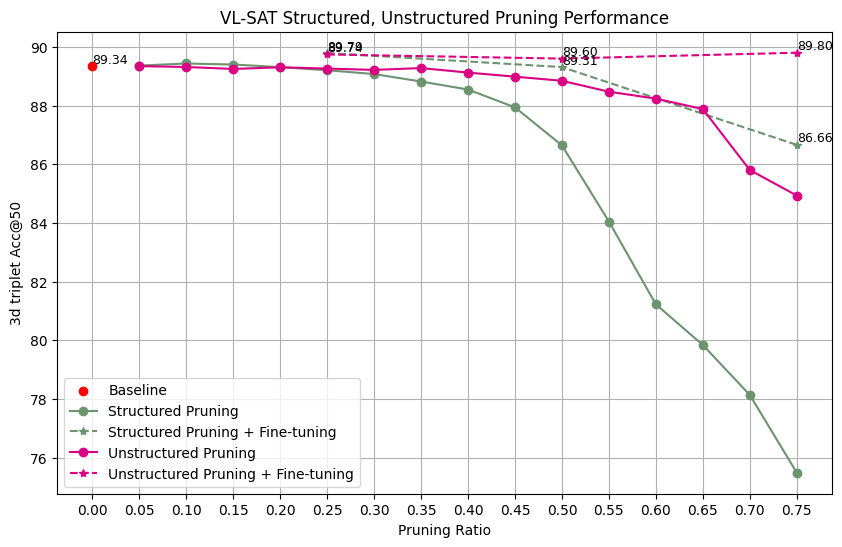

In [5]:
title = 'VL-SAT Structured, Unstructured Pruning Performance'
base_path_structured = '/home/knuvi/Desktop/song/lightweight_3DSSG/config/results/Mmgnet/eval_mmg_st'  # 여기에 실제 구조화된 폴더 경로를 넣으세요
base_path_unstructured = '/home/knuvi/Desktop/song/lightweight_3DSSG/config/results/Mmgnet/eval_mmg_unst'  # 여기에 실제 비구조화된 폴더 경로를 넣으세요

structured_results = process_folders(base_path_structured, structured=True)
unstructured_results = process_folders(base_path_unstructured, structured=False)    
# 추가 학습 후 결과 직접 입력 (구조화된 및 비구조화된)
additional_structured_results = [
    (0.25, 89.79),  # (Pruning Ratio, 3d triplet Acc@50)
    (0.50,89.31),
    (0.75, 86.66)
]
additional_unstructured_results = [
    (0.25, 89.74),  # (Pruning Ratio, 3d triplet Acc@50)
    (0.50, 89.6),
    (0.75, 89.8)
]

for ratio, triplet_acc_50, _ in structured_results:
    print(f"Structured - Pruning Ratio: {ratio}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

for ratio, triplet_acc_50, _ in unstructured_results:
    print(f"Unstructured - Pruning Ratio: {ratio}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

for ratio, triplet_acc_50 in additional_structured_results:
    print(f"Additional Structured Training - Pruning Ratio: {ratio}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

for ratio, triplet_acc_50 in additional_unstructured_results:
    print(f"Additional Unstructured Training - Pruning Ratio: {ratio}, Eval: 3d triplet Acc@50: {triplet_acc_50}")

plot_results(title, structured_results, unstructured_results, additional_structured_results, additional_unstructured_results)